In [3]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code


In [4]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

In [233]:
from lib.lib import get_trajs,get_pt_plus

In [234]:
fig_dir='../../output/figures/'
data_dir='../../output/data/'

## Generate trajectory ensemble

In [235]:
df_traj=get_trajs()
df_traj.head()

,seq,Nt,nCorrectChoice,p_plus,p_success
0,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...",False,"[0.5, 0.3952636718750002, 0.2905273437500001, ...","[0.5, 0.6047363281249998, 0.7094726562499999, ..."
1,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...",False,"[0.5, 0.3952636718750002, 0.2905273437500001, ...","[0.5, 0.6047363281249998, 0.7094726562499999, ..."
2,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...",False,"[0.5, 0.3952636718750002, 0.2905273437500001, ...","[0.5, 0.6047363281249998, 0.7094726562499999, ..."
3,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...",False,"[0.5, 0.3952636718750002, 0.2905273437500001, ...","[0.5, 0.6047363281249998, 0.7094726562499999, ..."
4,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...",False,"[0.5, 0.3952636718750002, 0.2905273437500001, ...","[0.5, 0.6047363281249998, 0.7094726562499999, ..."


Compute $P_{T|t}^+$ for all trajectories

In [236]:
def dummy(row):
    return np.array([get_pt_plus(t,Nt) for t,Nt in enumerate(row)])
df_traj['Pt_plus']=df_traj.Nt.apply(lambda x: dummy(x))
# df_traj['evidence']=df_traj.Pt_plus.apply(lambda x: np.log(x/(1-x)))
df_traj['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)

In [237]:
para=dict()
para['T']=15
para['T_ITI']=7.5#para['T']/2=7.5 in primate experiments set to 8 so that all trial durations are integers
para['p']=1/2

## Dynamic Programming Model

In [238]:
from lib.dyn_prog_model import *

In [239]:
from lib.plotting import plot_nocost_dec_times

In [258]:
dfb=df_traj.copy()
dfb.columns

Index(['seq', 'Nt', 'nCorrectChoice', 'p_plus', 'p_success', 'Pt_plus',
       'plus'],
      dtype='object')

## $(\alpha,c)$ Grid

## ARRL 

In [241]:
import time
from lib.lib import get_survprob

In [242]:
npoints=40
cost_vec=np.linspace(0,0.05,npoints)
alpha_vec=np.linspace(0.001,0.999,npoints)

In [272]:
RR_Store_grid=np.zeros((npoints,npoints))
tdec_Store_grid=np.zeros((npoints,npoints))
st=time.time()
for ait,alp in enumerate(alpha_vec):
    for cit,scalar_cost_value in enumerate(cost_vec):
        cost_seq=scalar_cost_value*np.ones(para['T']+1)
        rho_zero,data_boundary,dec_data,cost_seq,_=get_DP_boundary(cost_seq,1-alp)
        RR_Store_grid[ait,cit]=rho_zero
        
        tb,b_bel=data_boundary[1]
        b_beltmp=[]
        for t in range(para['T']+1):
            teff=t-(para['T']-len(b_bel))-1
            b_beltmp.append(b_bel[teff] if teff>=0 else 1)
        b_beltmp=np.asarray(b_beltmp)
        dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
        tdec_Store_grid[ait,cit]=dfb['tDecision'].mean()
print(time.time()-st)

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/lib.py:87: RuntimeWarning: divide by zero encountered in log2
  return 2**(-(T-t)+np.log2(np.sum( [binomial(T - t,k) for k in kvec])))


552.0073480606079


In [27]:
np.save(data_dir+'RR_Store_grid.npy',RR_Store_grid)
np.save(data_dir+'tdec_Store_grid.npy',tdec_Store_grid)

In [243]:
RR_Store_grid=np.load(data_dir+'RR_Store_grid.npy')
tdec_Store_grid=np.load(data_dir+'tdec_Store_grid.npy')

### one and done

In [255]:
RR_onedone_store=np.zeros((npoints,npoints))
st=time.time()
for ait,alp in enumerate(alpha_vec):
    for cit,scalar_cost_value in enumerate(cost_vec):
        RR_onedone_store[ait,cit]=(get_pt_plus(1,1)-scalar_cost_value)/get_trial_duration(1,alp)

### wait for certainty

In [260]:
b=1
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b,x<=1-b))[0][0] if np.where(np.logical_or(x>=b,x<=1-b))[0].size else para['T'])
#         dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1)
RR_wait4certain_store=np.zeros((npoints,npoints))
for ait,alp in enumerate(alpha_vec): 
    partdur=partial(get_trial_duration,alpha=alp)
    for cit,scalar_cost_value in enumerate(cost_vec):
        RR_wait4certain_store[ait,cit]=(dfb.prob_corr_at_tdec-scalar_cost_value*dfb.tb).mean()/(dfb.tb.apply(partdur).mean())    

### random

In [261]:
RR_random_store=np.zeros((npoints,npoints))
p_act_rand=2/3
tdec_mean_fullrand=1/p_act_rand+1
for ait,alp in enumerate(alpha_vec): 
    for cit,scalar_cost_value in enumerate(cost_vec):
        RR_random_store[ait,cit]=(1/2-scalar_cost_value*tdec_mean_fullrand)/get_trial_duration(tdec_mean_fullrand,alp) 

In [276]:
dataroot='../../exp_data/Thiery_etal_2022/tdms/'
import time
import os
from nptdms import TdmsFile
num_subjects=32
subject_list=['H'+str(x) for x in range(1,num_subjects+1)]
for ind in range(1,9):
    subject_list[ind]='H0'+str(ind+1)
st=time.time()   
df=pd.DataFrame()
for subject in subject_list:
    file_list=os.listdir(dataroot+subject)
    for file_name in file_list:
        if ('Fast' in file_name or 'Slow' in file_name) and ('index' not in file_name) :
            cond='slow' if 'Slow' in file_name else 'fast'
            tdms_file = TdmsFile.read(dataroot+subject+'/'+file_name)#'H1Fast1_180131.tdms")
            num_trials=int(len(tdms_file.groups())/4)
            dftmp=pd.DataFrame()
            for trial in range(1,num_trials):
                group=tdms_file['TrialData_'+str(trial)]
                data=[x.replace(' ','') for x in group.properties['Events'].split('\r\n')]
                data=[tuple(x.split(':',1)) for x in data[:18]]
                data_dict=dict(data)
                dftmp=dftmp.append(data_dict,ignore_index=True)
            dftmp['subject']=subject
            dftmp['cond']=cond
            df=pd.concat([df, dftmp], ignore_index=True, axis=0)
print(time.time()-st)
import datetime
def dummy(datastring):
    tmp=[x for x in datastring[1:11].split('/')+datastring[11:-3].split(':')]
    tmp=tmp[:-1]+tmp[-1].split('.')
    tmp=[int(x) for x in tmp]
    tmp[3]=tmp[3] if datastring[-2:]=='AM' else tmp[3]+12
    tmp[-1]*=1000 #microsecond units
    return datetime.datetime(*tmp)
df.dDate=df.dDate.apply(dummy)
for column in ['nChoiceMade', 'nCorrectChoice', 'nInitialTime', 'nOutcome','nSelectedTarget', 'nTrialIndex', 'nUnselectedTarget', 'tClick','tEnterCenter', 'tEnterTarget', 'tExitCenter', 'tGO', 'tTrialEnd']:
    df[column]=df[column].astype('int')
df.nCorrectChoice=2*(df.nCorrectChoice.values.astype('int')-1)-1 #assuming 1=False, 2=True
df.nChoiceMade=2*(df.nChoiceMade.values.astype('int')-1)-1 #assuming 1=False, 2=True
df['seq']=df.sTokenDirs.apply(lambda x:2*(np.asarray([int(el) for el in list(str(x[1:-1]))])-1)-1)
df.seq=df.seq.apply(lambda row: np.diff(row))
df['tDecision']=(df.tExitCenter-df.tGO)/200.
df['reward']=(df.nChoiceMade==df.nCorrectChoice)
df['alp']=df.cond.apply(lambda x: 0.25 if x=='slow' else 0.75)
def dummy(row):
    return get_trial_duration(row.tDecision,row.alp)
df['duration']=df.apply(dummy,axis=1)
subject_reward_rates=(df.loc[df.sTrialClass=="'x'"].groupby(['subject','cond']).reward.sum()/df.loc[df.sTrialClass=="'x'"].groupby(['subject','cond']).duration.sum())

Human_mean_vec=subject_reward_rates.groupby('cond').mean().values
Human_std_vec=subject_reward_rates.groupby('cond').std().values

70.65222477912903


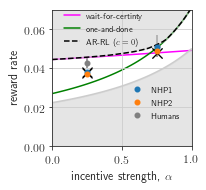

In [336]:
RR_Store=RR_Store_grid
fig,ax=pl.subplots(1,1,figsize=(2.5,2.5))

#strategies
colors=pl.rcParams['axes.prop_cycle'].by_key()['color']
p1=ax.plot(alpha_vec,RR_wait4certain_store[:,0],'-',color='magenta',label='wait-for-certinty',zorder=0)
wait4cer_color=p1[-1].get_color()
p2=ax.plot(alpha_vec,RR_onedone_store[:,0],'-',color='green',label='one-and-done',zorder=0)#,label='one-and-done')#step: $a_{1}=N_{1}$')
onedone_color=p2[-1].get_color()
p3=ax.plot(alpha_vec,RR_Store[:,0],'k--',label=r'AR-RL ($c=0$)')#,label='optimal belief bound',clip_on=False)

ax.plot(alpha_vec,RR_random_store[:,0],'-',color=[0.8]*3)#,label=r'uniform random: $p_{a_t}=1/3$')

gray_val=0.8
ax.fill_between(alpha_vec,RR_Store[:,0], [0.07]*(len(alpha_vec)),color=[gray_val]*3,alpha=0.5)
ax.fill_between(alpha_vec,np.zeros(alpha_vec.shape),rew_fullrand,color=[gray_val]*3,alpha=0.5)

l2=ax.plot([1-1/4,1-3/4],NHP_reward_rates[0].values,'o',label='NHP1',zorder=3,ms=4)
l3=ax.plot([1-1/4,1-3/4],NHP_reward_rates[1].values,'o',label='NHP2',zorder=3,ms=4)
l1=ax.errorbar([0.25,0.75],Human_mean_vec[::-1],yerr=Human_std_vec[::-1],fmt='o',color='gray',zorder=0,label='Humans',ms=4)
leg1=pl.legend([l2[0],l3[0],l1[0]],[l2[-1].get_label(),l3[-1].get_label(),l1.get_label()],frameon=False,fontsize=10,bbox_to_anchor=(0.5, 0.5),prop={'size':8})
ax.legend([p1[0],p2[0],p3[0]],[p[-1].get_label() for p in [p1,p2,p3]],frameon=False,fontsize=10,bbox_to_anchor=(0.7, 0.68),prop={'size':8})
ax.add_artist(leg1)

PGD_reward_rates=np.load(data_dir+'PGD_reward_rates.npy').item()
for subject in [1,2]:
    for nPost in [150,50]:
        ax.plot([1-nPost/200],[PGD_reward_rates[subject][nPost]],'kx',mew=1,ms=10,zorder=1)
ax.set_ylabel('reward rate')
ax.set_xlim(0,1)
ax.set_xlabel(r'incentive strength, $\alpha$')
ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.02,0.04,0.06])
ax.set_ylim(0,0.07)
fig.savefig('optimal_strategies.pdf', transparent=True,dpi=300,bbox_inches='tight')

In [315]:
PGD_reward_rates=np.load(data_dir+'PGD_reward_rates.npy').item()
PGD_reward_rates

{1: {150: 0.03819515164870878, 50: 0.04770539412970089},
 2: {150: 0.03730734438069863, 50: 0.047768220709515474}}

In [16]:
dfb=df_traj.copy()
Nt_samples=np.cumsum(np.asarray(dfb.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
survprob_data=[]
tmplist=[]
for dit,data_boundary in enumerate(boundary_list[0][::-1]):
    tmplist.append(get_survprob(dfb,Nt_samples,data_boundary,T=para['T']))
survprob_data.append(tmplist) 
tmplist=[]
for dit,data_boundary in enumerate(boundary_list[1][::-1]):
    tmplist.append(get_survprob(dfb,Nt_samples,data_boundary,T=para['T']))
survprob_data.append(tmplist) 

NameError: name 'boundary_list' is not defined

Slices

In [28]:
def get_Ntatdec(row):
    return row.Nt[row.tDecision]

In [21]:
dfb=df_traj.copy()   
alpvec_test=[0.1,0.25,0.4,0.6,0.75,0.9]
cost_slice_boundaries=[]
cost_slice_hist=[]
for cost_alpvec_test in [0.0,0.01]:
    scalar_cost_value=cost_alpvec_test
    cost_seq=scalar_cost_value*np.ones(para['T']+1)
    tmplist=[]
    tmphist=[]
    for ait,alp in enumerate(alpvec_test):
        rho_zero,data_boundary,dec_data,cost_seq,decide=get_DP_boundary(cost_seq,1-alp)
        tmplist.append(data_boundary) 
        
        tb,b_bel=data_boundary[1]
        b_beltmp=[]
        for t in range(para['T']+1):
            teff=t-(para['T']-len(b_bel))-1
            b_beltmp.append(b_bel[teff] if teff>=0 else 1)
        b_beltmp=np.asarray(b_beltmp)
        dfb['tDecision']=dfb.p_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
        dfb['Ntatdec']=dfb.apply(get_Ntatdec,axis=1)
        tmphist.append(dfb.loc[:,['tDecision','Ntatdec']].value_counts(normalize=True))
    cost_slice_boundaries.append(tmplist)
    cost_slice_hist.append(tmphist)
    
costvec_test=[0,0.01,0.02,0.03,0.04]
alp_slice_boundaries=[]
alp_slice_hist=[]
for alp_costvec_test in [0.25,0.75]:
    alpha=alp_costvec_test 
    tmplist=[]
    tmphist=[]
    for cit,scalar_cost_value in enumerate(costvec_test):
        cost_seq=scalar_cost_value*np.ones(para['T']+1)
        rho_zero,data_boundary,dec_data,cost_seq,decide=get_DP_boundary(cost_seq,1-alpha)
        tmplist.append(data_boundary)
        
        tb,b_bel=data_boundary[1]
        b_beltmp=[]
        for t in range(para['T']+1):
            teff=t-(para['T']-len(b_bel))-1
            b_beltmp.append(b_bel[teff] if teff>=0 else 1)
        b_beltmp=np.asarray(b_beltmp)
        dfb['tDecision']=dfb.p_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
        dfb['Ntatdec']=dfb.apply(get_Ntatdec,axis=1)
        tmphist.append(dfb.loc[:,['tDecision','Ntatdec']].value_counts(normalize=True))
        
    alp_slice_boundaries.append(tmplist)
    alp_slice_hist.append(tmphist)
slice_boundaries=(cost_slice_boundaries,alp_slice_boundaries)
slice_histdata=(cost_slice_hist,alp_slice_hist)

In [89]:
dftmp=df_act.loc[df_act.nPostInterval==150].tail(int(tail_num)).reset_index(drop=True)
dftmp['Ntatdec']=dftmp.apply(get_Ntatdec,axis=1)
actual_hist.append(dftmp.loc[:,['tDecision','Ntatdec']].value_counts(normalize=True))

#AR-RL
for cost_rate in np.linspace(0.02,0.03,10):
    rho_zero,data_boundary,dec_data,cost_seq,decide=get_DP_boundary(cost_rate*np.ones(para['T']+1),150/200)
#     print(rho_zero)
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dftmp['tDecisionARRL']=dftmp.p_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
    print(np.mean(np.fabs(dftmp.tDecisionARRL.values-dftmp.tDecision.values)))

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/lib.py:87: RuntimeWarning: divide by zero encountered in log2
  return 2**(-(T-t)+np.log2(np.sum( [binomial(T - t,k) for k in kvec])))


3.7578
3.7578
3.5091
3.5091
3.3827
3.2924
2.9389
3.3869
3.3869
3.3869


In [206]:
df_data=pd.read_pickle('../../exp_data/Thura_etal_2016/df_data_tdec_as_int.pkl')

In [207]:
df_data.columns

Index(['Nt', 'seq', 'nPostInterval', 'idSubject', 'nCorrectChoice',
       'tDecision', 'nChoiceMade', 'dDate', 'block_idx', 'p_plus', 'p_success',
       'duration', 'trialRR'],
      dtype='object')

In [295]:
df_data=pd.read_pickle('../../exp_data/Thura_etal_2016/df_data_tdec_as_int.pkl')
model_paras_S1_taus={'tau_context':646,
            'sense_power':11.703220, 
            'tau_long':45248,
                     'unitconv':1.0386
            }
subject=1
tail_num=len(df_data)#1e5
def dummy(row):
    return np.array([get_pt_plus(t,Nt) for t,Nt in enumerate(row)])
df_data['p_plus']=df_data.Nt.apply(lambda x: dummy(x))
df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
from lib.filter_lib import get_model_output
df_mod=get_model_output(df_act,model_paras_S1_taus)
df_mod['Nt']=df_act.Nt
actual_hist=[]
PGD_hist=[]
PGD_dtimes=[]
ARRL_dtimes=[]
opt_cost_rate=[0.0267,0]
for nit,npost in enumerate([150,50]):
    dftmp=df_act.loc[df_act.nPostInterval==npost].tail(int(tail_num)).reset_index(drop=True)
    dftmp['Ntatdec']=dftmp.apply(get_Ntatdec,axis=1)
    actual_hist.append(dftmp.loc[:,['tDecision','Ntatdec']].value_counts(normalize=True))
    
    #AR-RL
    rho_zero,data_boundary,dec_data,cost_seq,decide=get_DP_boundary(opt_cost_rate[nit]*np.ones(para['T']+1),npost/200)
    print(rho_zero)
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dftmp['tDecisionARRL']=dftmp.p_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
    ARRL_dtimes.append(dftmp.tDecisionARRL.values-dftmp.tDecision.values)
    
    #PGD
    dfmodtmp=df_mod.loc[df_mod.nPostInterval==npost].tail(int(tail_num)).reset_index(drop=True)
    dfmodtmp['Ntatdec']=dfmodtmp.apply(get_Ntatdec,axis=1)
    PGD_hist.append(dfmodtmp.loc[:,['tDecision','Ntatdec']].value_counts(normalize=True))
    PGD_dtimes.append(dfmodtmp.tDecision-dftmp.tDecision)

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/lib.py:149: RuntimeWarning: divide by zero encountered in log2


0.03249975790207338


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/lib.py:149: RuntimeWarning: divide by zero encountered in log2


0.05201892311014271


In [310]:
df_data=pd.read_pickle('../../exp_data/Thura_etal_2016/df_data_tdec_as_int.pkl')
def get_durations(row):
    alpha=0.25 if row.nPostInterval==150 else 0.75    
    return get_trial_duration(row.tDecision,alpha)
df_data.duration=df_data.apply(get_durations,axis=1)
NHP_reward_rates=[]
NHP_reward_rates_std=[]
for subject in [1,2]:
    df_act=df_data[df_data.idSubject==subject].tail(int(1e4)).reset_index(drop=True)
    df_act['reward']=(df_act.nChoiceMade==df_act.nCorrectChoice)
    for npost in [150,50]:
        print(df_act[df_act.nPostInterval==npost].reward.mean())
        print(df_act[df_act.nPostInterval==npost].duration.mean())
    df_act['rewardrate']=df_act.reward/df_act.duration
    rewards=df_act.groupby('nPostInterval').reward  
    durations=df_act.groupby('nPostInterval').duration
    NHP_reward_rates.append(df_act.groupby('nPostInterval').rewardrate.mean())
#     NHP_reward_rates.append(rewards.sum()/durations.sum())
    rew_std=rewards.std()/np.sqrt(df_act.groupby('nPostInterval').size())
    dur_std=durations.std()/np.sqrt(df_act.groupby('nPostInterval').size())
    NHP_reward_rates_std.append(NHP_reward_rates[subject-1]*np.sqrt(rew_std*rew_std/(rewards.mean()*rewards.mean())))
    print(NHP_reward_rates[subject-1])
    print(NHP_reward_rates_std[subject-1])

0.7877332141660149
20.654843034297844
0.7559580552907531
14.894184938036226
nPostInterval
50.0     0.050957
150.0    0.038198
Name: rewardrate, dtype: float64
nPostInterval
50.0     0.000894
150.0    0.000210
dtype: float64
0.7582107596211969
20.631472899455975
0.695850704784594
14.367182846932698
nPostInterval
50.0     0.049029
150.0    0.036837
Name: rewardrate, dtype: float64
nPostInterval
50.0     0.000457
150.0    0.000295
dtype: float64


In [309]:
df_act.groupby('nPostInterval').rewardrate.apply(mean)

NameError: name 'mean' is not defined

In [106]:
n_PGDfast=len(PGD_dtimes[1])
n_PGDslow=len(PGD_dtimes[0])
n_ARRLfast=len(ARRL_dtimes[1])
n_ARRLslow=len(ARRL_dtimes[0])
print(str(n_PGDfast)+' '+str(n_PGDslow)+' '+str(n_ARRLfast)+' '+str(n_ARRLslow))

36274 66897 36274 66897


Dn,m=0.3314426189058301 >0.009463748182756214
Dn,m=0.25778794729007004 >0.012851942463039397


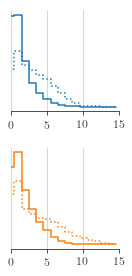

In [296]:
#plot errors
fig,ax=pl.subplots(2,1,figsize=(2,4))
dtimevec=np.arange(-1,16)
for ait,axx in enumerate(ax):
    PGD_counts,bins=np.histogram(np.fabs(PGD_dtimes[ait].values),bins=dtimevec,density='True')
    axx.step(dtimevec[:-1]+0.5,PGD_counts,'C'+str(ait))
    ARRL_counts,bins=np.histogram(np.fabs(ARRL_dtimes[ait]),bins=dtimevec,density='True')
    axx.plot(dtimevec[:-1]+0.5,ARRL_counts,'C'+str(ait),ls=':',drawstyle='steps')
    
    n_PGD=len(PGD_dtimes[ait])
    n_ARRL=len(ARRL_dtimes[ait])
    alpha_level=0.005
    thresh=np.sqrt(-np.log(alpha_level/2)*(1+n_PGD/n_ARRL)/(2*n_ARRL))
    
    total_variation_distance=np.max(np.fabs(np.cumsum(PGD_counts)-np.cumsum(ARRL_counts)))
    
    print('Dn,m='+str(total_variation_distance)+' >'+str(thresh))
    axx.spines['right'].set_visible(False)
    axx.spines['top'].set_visible(False)
    axx.spines['left'].set_visible(False)
    axx.yaxis.grid(False)
    axx.set_yticks([])
    axx.set_xlim(0,15)
fig.tight_layout()

Dn,m=0.3314426189058301 >0.009463748182756214
Dn,m=0.25778794729007004 >0.012851942463039397


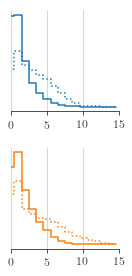

In [108]:
#plot errors
fig,ax=pl.subplots(2,1,figsize=(2,4))
dtimevec=np.arange(-1,16)
for ait,axx in enumerate(ax):
    PGD_counts,bins=np.histogram(np.fabs(PGD_dtimes[ait].values),bins=dtimevec,density='True')
    axx.step(dtimevec[:-1]+0.5,PGD_counts,'C'+str(ait))
    ARRL_counts,bins=np.histogram(np.fabs(ARRL_dtimes[ait]),bins=dtimevec,density='True')
    axx.plot(dtimevec[:-1]+0.5,ARRL_counts,'C'+str(ait),ls=':',drawstyle='steps')
    
    n_PGD=len(PGD_dtimes[ait])
    n_ARRL=len(ARRL_dtimes[ait])
    alpha_level=0.005
    thresh=np.sqrt(-np.log(alpha_level/2)*(1+n_PGD/n_ARRL)/(2*n_ARRL)) #kolmogorov-Smirnov test
    
    total_variation_distance=np.max(np.fabs(np.cumsum(PGD_counts)-np.cumsum(ARRL_counts)))
    
    print('Dn,m='+str(total_variation_distance)+' >'+str(thresh))
    axx.spines['right'].set_visible(False)
    axx.spines['top'].set_visible(False)
    axx.spines['left'].set_visible(False)
    axx.yaxis.grid(False)
    axx.set_yticks([])
    axx.set_xlim(0,15)
fig.tight_layout()

In [54]:
def get_hist(df_data,T=para['T']):
    #decision event histogram over trial ensemble 
    dec_counts=np.zeros((T+1,T+1))
    for it,tdec in enumerate(df_data.tDecision.values):
        curr_traj=df_data.seq.iloc[it]
        dec_counts[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm). int rounds down so should include current state. -1 to map to traj time index,  
    #add t=0 data
    dec_counts[0,0]=(df_data.tDecision==0).sum()

    #decision event histogram over state visitation ensemble
    occupancy_predec_counts=np.zeros((T+1,T+1))
    Nt_samples=np.cumsum(np.asarray(df_data.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
    tdec_vec=df_data.tDecision.apply(lambda x:int(x)).values
    for Np in np.arange(T+1):
        for Nm in np.arange(T+1):
            if Np+Nm<=T and Np+Nm>0:#=0
                occupancy_predec_counts[Np,Nm]=np.sum(Nt_samples[tdec_vec-1>=Np+Nm-1,Np+Nm-1]==Np-Nm) 
    occupancy_predec_counts[0,0]=len(df_data)  #all trajs go through (N_p=0,N_m=0).
    
    tdec_vec=df_data.tDecision.apply(lambda x:int(x)).values
    surv_prob=np.zeros((T+1,T+1))
    for Np in np.arange(T+1):
        for Nm in np.arange(T+1):
            if Np+Nm<=T and Np+Nm>0:#=0
                surv_prob[Np,Nm]=np.sum(tdec_vec[Nt_samples[:,Np+Nm-1]==Np-Nm]>Np+Nm)/np.sum(Nt_samples[:,Np+Nm-1]==Np-Nm) 
    surv_prob[0,0]=1  
    surv_prob[np.isnan(surv_prob)]=0
    
    return np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0),surv_prob

../lib/utils/ipynb_setup.py:25: RuntimeWarning: invalid value encountered in long_scalars
  
../lib/utils/ipynb_setup.py:29: RuntimeWarning: invalid value encountered in true_divide
  from IPython.display import Math
../lib/utils/ipynb_setup.py:29: RuntimeWarning: invalid value encountered in true_divide
  from IPython.display import Math
../lib/utils/ipynb_setup.py:25: RuntimeWarning: invalid value encountered in long_scalars
  
../lib/utils/ipynb_setup.py:29: RuntimeWarning: invalid value encountered in true_divide
  from IPython.display import Math
../lib/utils/ipynb_setup.py:25: RuntimeWarning: invalid value encountered in long_scalars
  
../lib/utils/ipynb_setup.py:29: RuntimeWarning: divide by zero encountered in true_divide
  from IPython.display import Math
../lib/utils/ipynb_setup.py:29: RuntimeWarning: invalid value encountered in true_divide
  from IPython.display import Math
../lib/utils/ipynb_setup.py:29: RuntimeWarning: invalid value encountered in true_divide
  from IPyt

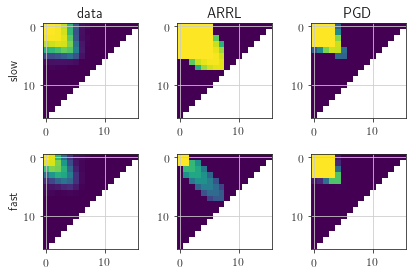

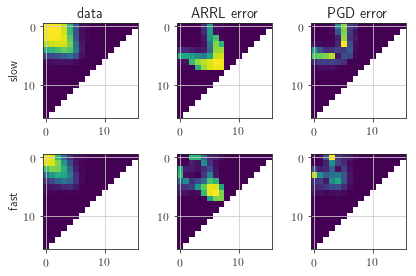

In [55]:
df_data=pd.read_pickle('../../exp_data/Thura_etal_2016/df_data_tdec_as_int.pkl')
subject=1
df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
error_store=[]
fig_hist,ax_hist=pl.subplots(2,3,figsize=(6,4))
fig_sp,ax_sp=pl.subplots(2,3,figsize=(6,4))

for ait,alp in enumerate([0.25,0.75]):  
    #data
    dftmp=df_act.loc[df_act.nPostInterval==200*(1-alp)].tail(int(1e4)).reset_index(drop=True)
    data_hist,data_surv_prob=get_hist(dftmp)
    mask=np.fliplr(np.triu(np.ones([para['T']+1]*2)))
    mask[mask==0]=np.nan 
#     data_hist=get_survprob(df_data,df_data.Nt.tolist(),data_boundary,T=para['T'])
    ax_hist[ait,0].imshow(data_surv_prob*mask,cmap='viridis')
    ax_sp[ait,0].imshow(data_surv_prob*mask,cmap='viridis')

    #AR-RL
    rho_zero,data_boundary,dec_data,cost_seq,decide=get_DP_boundary(np.zeros(para['T']+1),1-alp)
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dfb=df_traj.copy()
    dfb['tDecision']=dfb.p_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
    ARRL_hist,ARRL_surv_prob=get_hist(dfb)
    ax_hist[ait,1].imshow(ARRL_surv_prob*mask,cmap='viridis')
    ax_sp[ait,1].imshow(mask*(1-data_surv_prob)*np.fabs(data_surv_prob-ARRL_surv_prob),cmap='viridis')

    #PGD
    model_paras_S1_taus={'tau_context':646,
            'sense_power':11.703220, 
            'tau_long':45248,
                     'unitconv':1.0386
            }
    df_mod=get_model_output(dftmp,model_paras_S1_taus)
    PGD_hist,PGD_surv_prob=get_hist(df_mod)
    ax_hist[ait,2].imshow(mask*PGD_surv_prob*mask,cmap='viridis')
    ax_sp[ait,2].imshow(mask*PGD_surv_prob*mask,aspect=1,cmap='viridis')
    ax_sp[ait,2].imshow(mask*(1-data_surv_prob)*np.fabs(data_surv_prob-PGD_surv_prob),cmap='viridis')

#     df_mod['Nt']=dftmp.Nt
#     df_mod['p_plus']=dftmp.p_plus
#     df_mod['p_success']=dftmp.p_success
    
#     error_PGD=0
#     error_ARRL=0
#     for Nm in range(para['T']+1):
#         for Np in range(para['T']+1):
#             if Nm+Np<=para['T']:
#                 error_PGD+= (1-data_surv_prob[Nm,Np])*np.fabs(np.power(data_surv_prob[Nm,Np]-PGD_surv_prob[Nm,Np],1))
#                 error_ARRL+= (1-data_surv_prob[Nm,Np])*np.fabs(np.power(data_surv_prob[Nm,Np]-ARRL_surv_prob[Nm,Np],1))
# #                 error_PGD+= get_Dkl(data_surv_prob[Nm,Np],PGD_surv_prob[Nm,Np])
# #                 error_ARRL+= get_Dkl(data_surv_prob[Nm,Np],ARRL_surv_prob[Nm,Np])
#                 eps=1e-1
# #                 error_PGD+= (data_surv_prob[Nm,Np]>eps)*(PGD_surv_prob[Nm,Np]>eps)
# #                 error_ARRL+= (data_surv_prob[Nm,Np]>eps)*(ARRL_surv_prob[Nm,Np]>eps)
    error_store.append([np.sum((1-data_surv_prob)*np.fabs(data_surv_prob-PGD_surv_prob)),np.sum((1-data_surv_prob)*np.fabs(data_surv_prob-ARRL_surv_prob))])
ax_sp[0,0].set_title('data')
ax_sp[0,1].set_title('ARRL error')
ax_sp[0,2].set_title('PGD error')
ax_hist[0,0].set_title('data')
ax_hist[0,1].set_title('ARRL')
ax_hist[0,2].set_title('PGD')
for ax in (ax_sp,ax_hist):
    ax[0,0].set_ylabel('slow')
    ax[1,0].set_ylabel('fast')
fig_hist.tight_layout()
fig_sp.tight_layout()
# fig_hist.savefig('modelcompare_survprob.pdf', transparent=True,dpi=300,bbox_inches='tight')
# fig_sp.savefig('modelcompare_survprob_error.pdf', transparent=True,dpi=300,bbox_inches='tight')

In [14]:
import matplotlib.gridspec as gridspec

In [24]:
t,Nt=list(map(list,zip(*actual_hist[tit].index)))
Nt=np.array(Nt)
t=np.array(t)

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


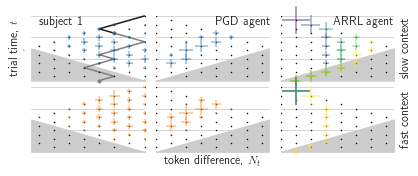

In [142]:
fig,ax=pl.subplots(2,3,figsize=(6.5,2.5),gridspec_kw={'hspace':0.1,'wspace':0.1})
col_arr=[pl.cm.inferno(np.linspace(0, 0.8, len(alpvec_test))),pl.cm.viridis(np.linspace(0, 1, len(costvec_test)))]

for pit,post_interval in enumerate([150,50]):
    
    #draw grid      
    for ait,axt in enumerate(ax[pit]):
        if ait==0:
            axt.set_xlim(-7.5,0)
        else:
            axt.set_xlim(0,7.5)
        axt.set_ylim(-15,0)
        axt.spines['right'].set_visible(False)
        axt.spines['top'].set_visible(False)
        axt.spines['left'].set_visible(False)
        axt.spines['bottom'].set_visible(False)
        point=8
        offset=0.5
        axt.fill_between([-7.5,0,7.5],[-7.5,-15,-7.5],[-15,-15,-15],color=[0.8]*3)
        for t in np.arange(para['T']):
            axt.plot(np.arange(-t,t+1,2),-t*np.ones(t+1),'ko',ms=1,lw=0.5,color=[0.9]*3,mew=0.5,mfc='k',mec='k',zorder=20)
        axt.set_yticks([-15,-10,-5,0])
        axt.set_yticklabels([])#str(-x) for x in [-15,-10,-5,0]])
        axt.set_xticks([])
        if pit==0:
            axt.set_xticklabels([])
        if ait>0:
            axt.set_yticklabels([])
        if pit==1 and ait==1:
            axt.set_xlabel('token difference, $N_t$')
        axt.xaxis.set_ticks_position('none')
        axt.yaxis.set_ticks_position('none')
#     ax[1,0].set_xticks([-5,0])
#     ax[1,1].set_xticks([0,5])
#     ax[1,2].set_xticks([0,5])
    
    #data
    t,Nt=list(map(list,zip(*actual_hist[pit].index)))
    Nt=np.array(Nt)
    t=np.array(t)
    mask=Nt<=0
    ms_factor=1500
    ax[pit,0].scatter(Nt[mask],-t[mask],s=actual_hist[pit].values[mask]*ms_factor,marker='+',color='C'+str(pit),zorder=50,clip_on=False,alpha=0.5)
    
    #PGD
    t,Nt=list(map(list,zip(*PGD_hist[pit].index)))
    Nt=np.array(Nt)
    t=np.array(t)
    mask=Nt>=0
    ax[pit,1].scatter(Nt[mask],-t[mask],s=PGD_hist[pit].values[mask]*ms_factor,marker='+',color='C'+str(pit),zorder=50,clip_on=False,alpha=0.5)
    
    #ARRL
    for dit,hist_data in enumerate(slice_histdata[tit][pit][::-1]):
        t,Nt=list(map(list,zip(*hist_data.index)))
        Nt=np.array(Nt)
        t=np.array(t)
        mask=Nt>=0
        ax[pit,2].scatter(Nt[mask],-t[mask],s=hist_data.values[mask]*ms_factor,marker='+',color=col_arr[tit][dit],zorder=50,clip_on=False,alpha=0.5)
example_token_seq=df_data[df_data.Nt.apply(lambda x:np.all(x<=0))].iloc[1].Nt
ax[0,0].plot(example_token_seq[:5],-np.arange(5),'-',color=[0.1]*3,clip_on=False)
ax[0,0].plot(example_token_seq[4:],-np.arange(4,16),'-',color=[0.5]*3,clip_on=False)
ax[0,0].plot([example_token_seq[-1]],[-15],'o',color=[0.5]*3,ms=2,clip_on=False)
ax[0,0].plot([example_token_seq[4]],[-4],'ko',color=[0.5]*3,ms=2,clip_on=False)
ax[0,0].text(-7,-2,'subject 1')
ax[0,1].text(4,-2,'PGD agent')
ax[0,2].text(3.5,-2,'ARRL agent')
ax[0,2].set_ylabel('slow context')
ax[0,2].yaxis.set_label_position("right")
ax[0,0].set_ylabel('trial time, $t$')
# ax[0,].set_ylabel('trial time, $t$')
ax[1,2].set_ylabel('fast context')
ax[1,2].yaxis.set_label_position("right")
fig.tight_layout()
fig.savefig('optimal_strategies_symcompare.pdf', transparent=True,dpi=300,bbox_inches='tight')

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


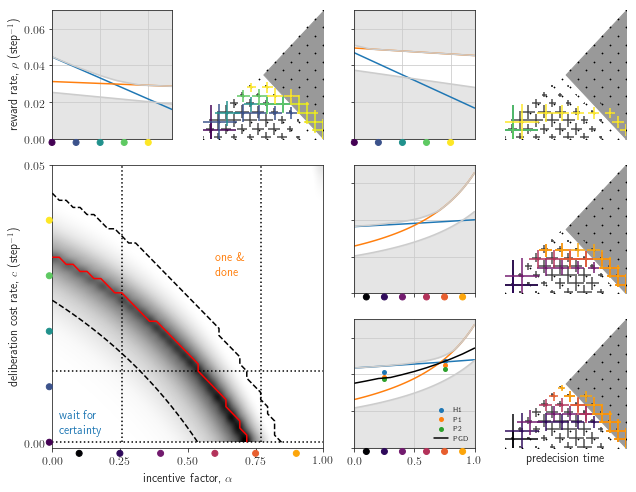

In [275]:
fig=pl.figure(constrained_layout=True,figsize=(9,7))
spec=gridspec.GridSpec(ncols=4,nrows=3,figure=fig)
axplane=fig.add_subplot(spec[1:,:-2])
slice_strat_inds=[[[(2,2),(2,3)],[(1,2),(1,3)]],[[(0,0),(0,1)],[(0,2),(0,3)]]]
ymax=0.07
xsamplevec=()
col_arr=[pl.cm.inferno(np.linspace(0, 0.8, len(alpvec_test))),pl.cm.viridis(np.linspace(0, 1, len(costvec_test)))]

for tit,typepairs in enumerate(slice_strat_inds):
    if tit==0:
        xlim=[0,1]
        xvec=alpha_vec
        slice_inds=[0,10]
        for sl in slice_inds:
            axplane.plot(alpha_vec[[0,-1]],[cost_vec[sl]]*2,'k:')
    else:
        xlim=[0,np.max(cost_vec)]
        xvec=cost_vec
        slice_inds=[10,30]
        for sl in slice_inds:
            axplane.plot([alpha_vec[sl]]*2,cost_vec[[0,-1]],'k:')
    for pit,pair in enumerate(typepairs):
        axslice=fig.add_subplot(spec[pair[0]])
        axstrat=fig.add_subplot(spec[pair[1]])
        slice_obj=np.s_[:,slice_inds[pit]] if tit==0 else np.s_[slice_inds[pit],:]
        #strategies
        # ax.plot(gamma_vec,rew_b,'-',label=r'optimal fixed bound: $b=b_{\textrm{opt}}(\alpha)$')
        axslice.plot(xvec,RR_wait4certain_store[slice_obj],'C0-')#,label=r'100\% accuracy $(b=1)$')
#         wait4cer_color=p[-1].get_color()
        # ax.text(0.6,1.07/(T+T_I),r'$\frac{1}{\bar{t}_{b=1}+\alpha (T-\bar{t}_{b=1})+T_{\textrm{I}}}$',color=colors[2])
        p=axslice.plot(xvec,RR_onedone_store[slice_obj],'C1-')#,label='one-and-done')#step: $a_{1}=N_{1}$')
#         onedone_color=p[-1].get_color()
        # ax.text(0.1,3/(2*(T+T_I)),r'$\frac{p_{\textrm{success}}(t^\pi_{\textrm{dec}}=1)}{1+\alpha(T-1)+T_{\textrm{I}}}$',color=colors[3])
        axslice.plot(xvec,RR_Store_grid[slice_obj],'-',color=[0.8]*3)#,label='optimal belief bound',clip_on=False)
        # gvec=np.linspace(0,1,100)
        # ax.plot(gvec,1/(2*(gvec*T+T_I)),'-',label=r'zero-step: $a_{0}=1$')
        # ax.text(0.7,0.8/(2*(T+T_I)),r'$\frac{1/2}{\alpha T+T_{\textrm{I}}}$',color=colors[4])
        axslice.plot(xvec,RR_random_store[slice_obj],'-',color=[0.8]*3)#,label=r'uniform random: $p_{a_t}=1/3$')
        # ax.text(0.1,1.3/(2*(T+T_I)),r'$\frac{1/2}{5/2+\alpha(T-5/2)+T_{\textrm{I}}}$',color=colors[5])
        gray_val=0.8
        axslice.fill_between(xvec,RR_Store_grid[slice_obj], [ymax]*(len(xvec)),color=[gray_val]*3,alpha=0.5)
        axslice.fill_between(xvec,np.zeros(xvec.shape),RR_random_store[slice_obj],color=[gray_val]*3,alpha=0.5)
#         axslice.text(0.3,0.06,r'better than best')
#         axslice.text(0.25,0.01,r'worse than random')
       
        #data
        rr_M1_fast=0.04489874703443582
        rr_M1_slow=0.038475184652453864
        rr_M2_fast=0.0427570104760277
        rr_M2_slow=0.03724601256317603
        rr_H1_fast=0.04716158428767893
        rr_H1_slow=0.04132889498676728
        if tit==0:
            axslice.scatter(alpvec_test,[-0.002]*len(alpvec_test),marker='o',c=col_arr[tit],clip_on=False,zorder=50)
            if pit==0:
                axslice.plot([1-1/4,1-3/4],[rr_H1_fast,rr_H1_slow],'.',label='H1')
                axslice.plot([1-1/4,1-3/4],[rr_M1_fast,rr_M1_slow],'.',label='P1')
                axslice.plot([1-1/4,1-3/4],[rr_M2_fast,rr_M2_slow],'.',label='P2')
                axslice.plot(heuristic_alpvec,heuristic,'k-',label='PGD')
                axslice.legend(frameon=False,prop={'size':7},loc=4)

        else:
            axslice.scatter(costvec_test,[-0.002]*len(costvec_test),marker='o',c=col_arr[tit],clip_on=False,zorder=50)

            
#         shift=0.025
#         axslice.text(1-3/4+shift,rr_H1_slow,'H1',ha='left',va='bottom',fontsize=14)
#         axslice.text(1-3/4+shift,rr_M1_slow,'P1',ha='left',va='center',fontsize=14)
#         axslice.text(1-3/4+shift,rr_M2_slow,'P2',ha='left',va='top',fontsize=14)
#                axslice.set_xlim(xlim[0],xlim[1])
        # ax[0,0].legend(frameon=False,loc=7,fontsize=10)#,bbox_to_anchor=(1.0, 1.05))
#         axslice.set_xticklabels([])
#         axslice.set_yticklabels([])
        axslice.set_ylim([0,ymax])
        axslice.set_xlim(xlim)
#         axslice.set_title(r'$c=0$')
        # ax[0,0].set_yticklabels([r'$0$','',r'$0.02$','',r'$0.04$','',r'$0.06$',''])
        # ax[0,0].text(-0.3,0.077,r'\underline{action policy}')
        # ax.set_title(r'$p_\textrm{jump}=1/2$, $T=15$ steps, $T_\textrm{inter}=T/2$')
        if tit==1 and pit==0:
            axslice.set_ylabel(r'reward rate, $\rho$ (step$^{-1}$)')#'=\frac{\langle p_{\textrm{success}}(t^\pi_{\textrm{dec}}) \rangle_{\tau}}{\langle T_{\textrm{trial}}(t^\pi_{\textrm{dec}})\rangle_{\tau}}$')
        else:
            axslice.set_yticklabels([])
            
        if tit==0 and pit==0:
#             axslice.set_xlabel(r'incentive, $\alpha$')#'=\frac{\langle p_{\textrm{success}}(t^\pi_{\textrm{dec}}) \rangle_{\tau}}{\langle T_{\textrm{trial}}(t^\pi_{\textrm{dec}})\rangle_{\tau}}$')
            axstrat.set_xlabel(r'predecision time')#'=\frac{\langle p_{\textrm{success}}(t^\pi_{\textrm{dec}}) \rangle_{\tau}}{\langle T_{\textrm{trial}}(t^\pi_{\textrm{dec}})\rangle_{\tau}}$')
        else:
            axslice.set_xticklabels([])

           
#         offset=0.15*np.arange(len(slice_boundaries[tit][pit]))
#         for dit,data_boundary in enumerate(slice_boundaries[tit][pit][::-1]):
#             tb,b_evi=data_boundary[0]
#             axstrat.plot(tb,np.asarray(b_evi)+offset[dit],'o-',color=col_arr[tit][dit],ms=3*(1-dit/len(slice_boundaries[tit][pit])))
        t,Nt=list(map(list,zip(*actual_hist[tit].index)))
        ms_factor=5000
        axstrat.scatter(np.array(t)-0.15,np.array(Nt)+0.15,s=actual_hist[tit]*ms_factor,marker='+',color=[0.3]*3,zorder=50)
        for dit,hist_data in enumerate(slice_histdata[tit][pit][::-1]):
            t,Nt=list(map(list,zip(*hist_data.index)))
            axstrat.scatter(t,Nt,s=hist_data.values*ms_factor,marker='+',color=col_arr[tit][dit],zorder=50)


            #     state_space=-np.inf*np.ones((para['T']+1,2*T+1))
#     for t in range(para['T']+1):
#         state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
#     ax[test_strat,1].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic')
#     for dit, data in enumerate(survprob_data[test_strat][::-1]):
#         ax[test_strat,1].contour(*data,levels=[0.5],linewidths=(1.5,),colors=[col_arr[test_strat][dit]],zorder=20)
        axstrat.set_xlim(0,15)
        axstrat.set_ylim(0,para['T'])
#         axstrat.set_xticks([0,1/3*para['T'],2/3*para['T'],para['T']]) 
        axstrat.set_xlim(0,para['T'])
#         axstrat.set_ylabel(r'token difference, $N_t$')
#         axstrat.set_xlabel(r'time (steps)')
        axstrat.spines['right'].set_visible(False)
        axstrat.spines['top'].set_visible(False)
        axstrat.spines['left'].set_visible(False)
        axstrat.spines['bottom'].set_visible(False)
        axstrat.set_xticks([])
        axstrat.set_yticks([])
        
        point=8
        offset=0.5
        axstrat.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
        axstrat.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
        for Nm in 2*np.arange(T):
            axstrat.plot(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
        for Np in 2*np.arange(T):
            axstrat.plot(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)


#phase diagra1

tmpdat=deepcopy(tdec_Store_grid)
# tmpdat[tdec_Store>1]=np.nan
# ax[1,0].contourf(alpha_vec,cost_vec,((RR_Store-np.maximum(RR_wait4certain_store,RR_onedone_store))**2).T,cmap='gray_r',levels=22)
# axplane.contour(alpha_vec,cost_vec,tdec_Store_grid.T,levels=range(5,16),colors=['k'],zorder=30)
axplane.contour(alpha_vec,cost_vec,tdec_Store_grid.T,levels=[1],colors=['k'],linestyles='dashed',zorder=30)
axplane.contour(alpha_vec,cost_vec,RR_Store_grid.T-RR_wait4certain_store.T,levels=[0.001],colors=['k'],linestyles='dashed',zorder=30)
# ax[1,0].contour(alpha_vec,cost_vec,tdec_Store.T,levels=[1.00001],colors=['k'],zorder=30)
axplane.contour(alpha_vec,cost_vec,(RR_wait4certain_store>RR_onedone_store).T,levels=[1.0000],colors=['r'],zorder=40)

# ax[1,0].imshow(tdec_Store.T,cmap='gray_r',interpolation='none',extent=[alpha_vec.min(),alpha_vec.max(),cost_vec.min(),cost_vec.max()],aspect='auto',origin='lower')
axplane.imshow(((RR_Store_grid-np.maximum(RR_wait4certain_store,RR_onedone_store))**2).T,cmap='gray_r',interpolation='spline36',extent=[alpha_vec.min(),alpha_vec.max(),cost_vec.min(),cost_vec.max()],aspect='auto',origin='lower')
# CS=axplane.contour(alpha_vec,cost_vec,RR_Store_grid,levels=10)
axplane.set_ylabel(r'deliberation cost rate, $c$ (step$^{-1}$)')
axplane.grid(None)
axplane.set_xlabel(r'incentive factor, $\alpha$')
axplane.set_yticks([0,0.05,0.1])
axplane.set_xlim(0,1)
axplane.set_ylim(-0.001,0.05)
axplane.set_xticks([0,0.25,0.5,0.75,1.0])
axplane.scatter(alpvec_test,[-0.002]*len(alpvec_test),marker='o',c=col_arr[0],clip_on=False,zorder=50)

axplane.scatter([-0.01]*len(costvec_test),costvec_test,marker='o',c=col_arr[1],clip_on=False,zorder=50)
# axplane.set_title('strategy domains')
# axplane.set_xticklabels([r'$0$',r'$0.5$',r'$1$'])
# ax[1,0].text(0.,-0.022,'no \n incentive',ha='center')
# ax[1,0].text(1.,-0.022,'max \n incentive',ha='center')
axplane.text(0.025,0.0015,'wait for \n certainty',color=wait4cer_color)
axplane.text(0.6,0.03,'one \& \n done',color=onedone_color)
# pl.colorbar(CS)



        

fig.tight_layout()
fig.savefig('optimal_strategies.pdf', transparent=True,dpi=300,bbox_inches='tight')

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


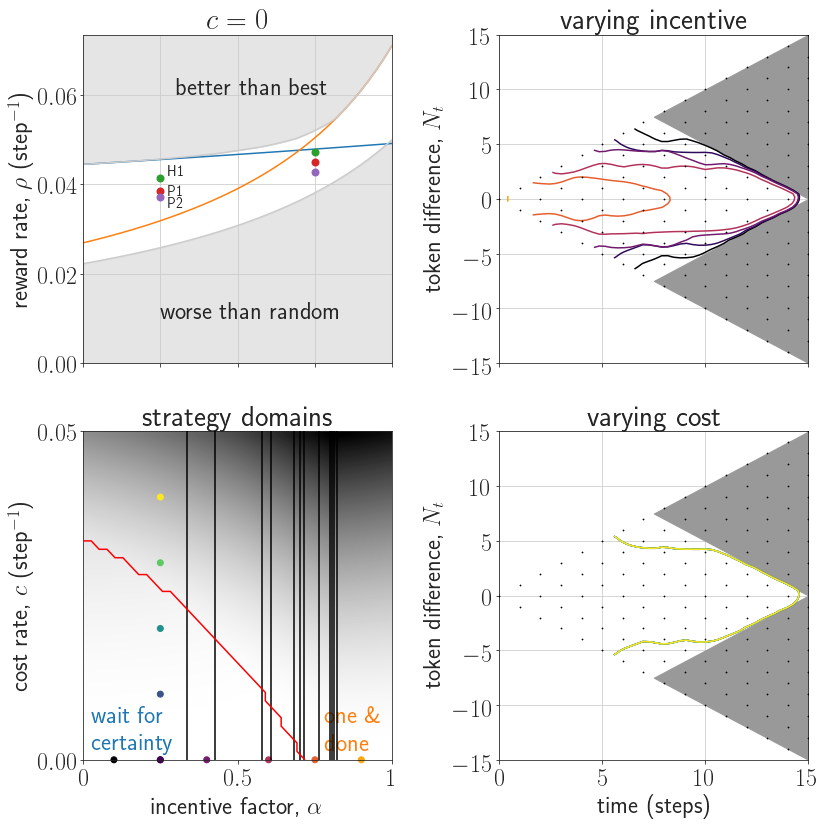

In [141]:
fig,ax=pl.subplots(2,2,figsize=(12,12))

#strategies
colors=pl.rcParams['axes.prop_cycle'].by_key()['color']
# ax.plot(gamma_vec,rew_b,'-',label=r'optimal fixed bound: $b=b_{\textrm{opt}}(\alpha)$')
p=ax[0,0].plot(alpha_vec,RR_wait4certain_store[:,0],'-')#,label=r'100\% accuracy $(b=1)$')
wait4cer_color=p[-1].get_color()
# ax.text(0.6,1.07/(T+T_I),r'$\frac{1}{\bar{t}_{b=1}+\alpha (T-\bar{t}_{b=1})+T_{\textrm{I}}}$',color=colors[2])
p=ax[0,0].plot(alpha_vec,get_pt_plus(1,1)/(1+(1-alpha_vec)*(para['T']-1)+para['T_ITI']),'-')#,label='one-and-done')#step: $a_{1}=N_{1}$')
onedone_color=p[-1].get_color()
# ax.text(0.1,3/(2*(T+T_I)),r'$\frac{p_{\textrm{success}}(t^\pi_{\textrm{dec}}=1)}{1+\alpha(T-1)+T_{\textrm{I}}}$',color=colors[3])
ax[0,0].plot(alpha_vec,RR_Store[:,0],'-',color=[0.8]*3)#,label='optimal belief bound',clip_on=False)
# gvec=np.linspace(0,1,100)
# ax.plot(gvec,1/(2*(gvec*T+T_I)),'-',label=r'zero-step: $a_{0}=1$')
# ax.text(0.7,0.8/(2*(T+T_I)),r'$\frac{1/2}{\alpha T+T_{\textrm{I}}}$',color=colors[4])
p_act_rand=2/3
tdec_mean_fullrand=1/p_act_rand+1
rew_fullrand=[1/2*1/(tdec_mean_fullrand+(1-alp)*(para['T']-tdec_mean_fullrand)+para['T_ITI']) for alp in alpha_vec]
ax[0,0].plot(alpha_vec,rew_fullrand,'-',color=[0.8]*3)#,label=r'uniform random: $p_{a_t}=1/3$')
# ax.text(0.1,1.3/(2*(T+T_I)),r'$\frac{1/2}{5/2+\alpha(T-5/2)+T_{\textrm{I}}}$',color=colors[5])
ylim=ax[0,0].get_ylim()
gray_val=0.8
ax[0,0].fill_between(alpha_vec,RR_Store[:,0], [ylim[1]]*(len(alpha_vec)),color=[gray_val]*3,alpha=0.5)
ax[0,0].fill_between(alpha_vec,np.zeros(alpha_vec.shape),rew_fullrand,color=[gray_val]*3,alpha=0.5)
ax[0,0].text(0.3,0.06,r'better than best')
ax[0,0].text(0.25,0.01,r'worse than random')

#data
rr_M1_fast=0.04489874703443582
rr_M1_slow=0.038475184652453864
rr_M2_fast=0.0427570104760277
rr_M2_slow=0.03724601256317603
rr_H1_fast=0.04716158428767893
rr_H1_slow=0.04132889498676728
ax[0,0].plot([1-1/4,1-3/4],[rr_H1_fast,rr_H1_slow],'o',label='H1')
ax[0,0].plot([1-1/4,1-3/4],[rr_M1_fast,rr_M1_slow],'o',label='P1')
ax[0,0].plot([1-1/4,1-3/4],[rr_M2_fast,rr_M2_slow],'o',label='P2')
shift=0.025
ax[0,0].text(1-3/4+shift,rr_H1_slow,'H1',ha='left',va='bottom',fontsize=14)
ax[0,0].text(1-3/4+shift,rr_M1_slow,'P1',ha='left',va='center',fontsize=14)
ax[0,0].text(1-3/4+shift,rr_M2_slow,'P2',ha='left',va='top',fontsize=14)
ax[0,0].set_ylabel(r'reward rate, $\rho$ (step$^{-1}$)')#'=\frac{\langle p_{\textrm{success}}(t^\pi_{\textrm{dec}}) \rangle_{\tau}}{\langle T_{\textrm{trial}}(t^\pi_{\textrm{dec}})\rangle_{\tau}}$')
ax[0,0].set_xlim(0,1)
# ax[0,0].legend(frameon=False,loc=7,fontsize=10)#,bbox_to_anchor=(1.0, 1.05))
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim([0,ylim[1]])
ax[0,0].set_title(r'$c=0$')
# ax[0,0].set_yticklabels([r'$0$','',r'$0.02$','',r'$0.04$','',r'$0.06$',''])
# ax[0,0].text(-0.3,0.077,r'\underline{action policy}')
# ax.set_title(r'$p_\textrm{jump}=1/2$, $T=15$ steps, $T_\textrm{inter}=T/2$')


#phase diagra1

tmpdat=deepcopy(tdec_Store)
tmpdat[tdec_Store>1]=np.nan
# ax[1,0].contourf(alpha_vec,cost_vec,((RR_Store-np.maximum(RR_wait4certain_store,RR_onedone_store))**2).T,cmap='gray_r',levels=22)
ax[1,0].contour(alpha_vec,cost_vec,tdec_Store.T,levels=range(1,16),colors=['k'],zorder=30)
# ax[1,0].contour(alpha_vec,cost_vec,tdec_Store.T,levels=[1.00001],colors=['k'],zorder=30)
ax[1,0].contour(alpha_vec,cost_vec,(RR_wait4certain_store>RR_onedone_store).T,levels=[1.0000],colors=['r'],zorder=30)

# ax[1,0].imshow(tdec_Store.T,cmap='gray_r',interpolation='none',extent=[alpha_vec.min(),alpha_vec.max(),cost_vec.min(),cost_vec.max()],aspect='auto',origin='lower')
ax[1,0].imshow(((RR_Store-np.maximum(RR_wait4certain_store,RR_onedone_store))**2).T,cmap='gray_r',interpolation='spline36',extent=[alpha_vec.min(),alpha_vec.max(),cost_vec.min(),cost_vec.max()],aspect='auto',origin='lower')
# CS=ax[1,0].contour(alpha_vec,cost_vec,RR_Store,levels=10)
ax[1,0].set_ylabel(r'cost rate, $c$ (step$^{-1}$)')
ax[1,0].grid(None)
ax[1,0].set_xlabel(r'incentive factor, $\alpha$')
ax[1,0].set_yticks([0,0.05,0.1])
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,0.05)
ax[1,0].set_xticks([0,0.5,1.0])
ax[1,0].set_title('strategy domains')
ax[1,0].set_xticklabels([r'$0$',r'$0.5$',r'$1$'])
# ax[1,0].text(0.,-0.022,'no \n incentive',ha='center')
# ax[1,0].text(1.,-0.022,'max \n incentive',ha='center')
ax[1,0].text(0.025,0.0015,'wait for \n certainty',color=wait4cer_color)
ax[1,0].text(0.78,0.0015,'one \& \n done',color=onedone_color)
# pl.colorbar(CS)

col_arr=[pl.cm.inferno(np.linspace(0, 0.8, len(alpvec_test))),pl.cm.viridis(np.linspace(0, 1, len(costvec_test)))]
ax[1,0].scatter(alpvec_test,[cost_alpvec_test]*len(alpvec_test),marker='o',c=col_arr[0],clip_on=False)
ax[1,0].scatter([alp_costvec_test]*len(costvec_test),costvec_test,marker='o',c=col_arr[1],clip_on=False)


        
offset=[np.asarray(alpvec_test)[::-1]/2,10*np.asarray(costvec_test[::-1])]
for test_strat in range(2):
#     for dit,data_boundary in enumerate(boundary_list[test_strat][::-1]):
#         tb,b_evi=data_boundary
        
#         ax[test_strat,1].plot(tb,np.asarray(b_evi)+offset[test_strat][dit],'.-')
        
#     state_space=-np.inf*np.ones((para['T']+1,2*T+1))
#     for t in range(para['T']+1):
#         state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
#     ax[test_strat,1].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic')
    for dit, data in enumerate(survprob_data[test_strat][::-1]):
        ax[test_strat,1].contour(*data,levels=[0.5],linewidths=(1.5,),colors=[col_arr[test_strat][dit]],zorder=20)
    ax[test_strat,1].set_xlim(0,15)
    ax[test_strat,1].set_ylim(-para['T'],para['T'])
    ax[test_strat,1].set_xticks([0,1/3*para['T'],2/3*para['T'],para['T']]) 
    ax[test_strat,1].set_xlim(0,para['T'])
    ax[test_strat,1].set_ylabel(r'token difference, $N_t$')
    ax[test_strat,1].set_xlabel(r'time (steps)')
    if test_strat==0:
        ax[test_strat,1].set_xticklabels([])
        ax[test_strat,1].set_xlabel('')
        ax[test_strat,1].set_title('varying incentive')
    else:
        ax[test_strat,1].set_title('varying cost')
    point=8
    offset=0.5
    ax[test_strat,1].fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
    ax[test_strat,1].fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
    for Nm in 2*np.arange(T):
        ax[test_strat,1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    for Np in 2*np.arange(T):
        ax[test_strat,1].plot(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
fig.tight_layout()
# fig.savefig('optimal_strategies.pdf', transparent=True,dpi=300,bbox_inches='tight')

# Constant cost

How to add a constant term to the integrated cost? Since value function recursvely defined from end of trial, a cost added at the beginning of the trial, plays no role in determing the the value function later in the trial...how is this possible? Not true. It will deviate V(t=0) which is zeroed by rho, so it affects later times via the deviated root of rho.

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/plotting.py:45: RuntimeWarning: invalid value encountered in true_divide
  dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/plotting.py:45: RuntimeWarning: invalid value encountered in true_divide
  dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.05201892311014271


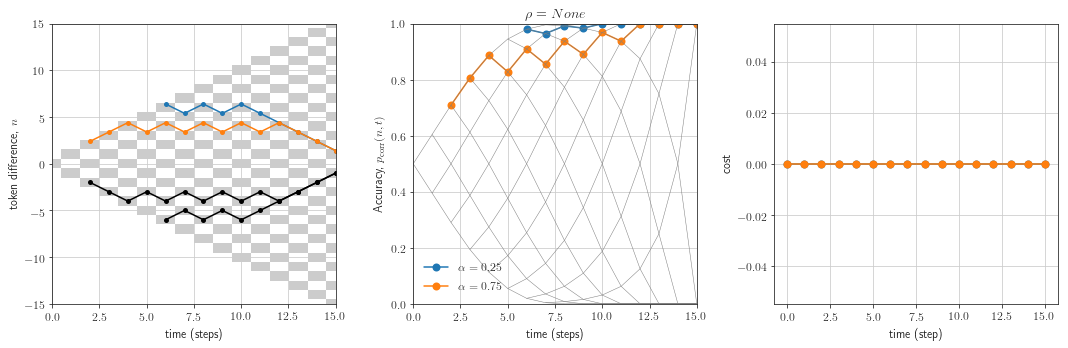

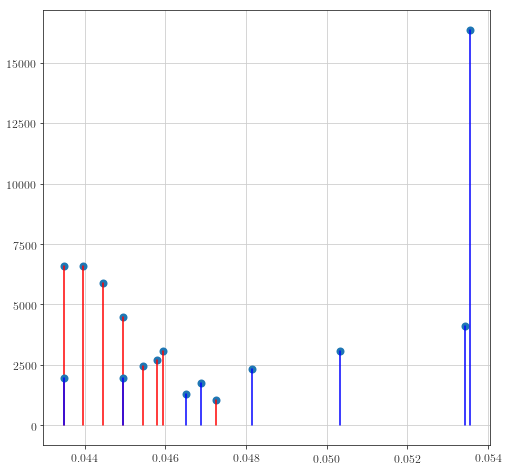

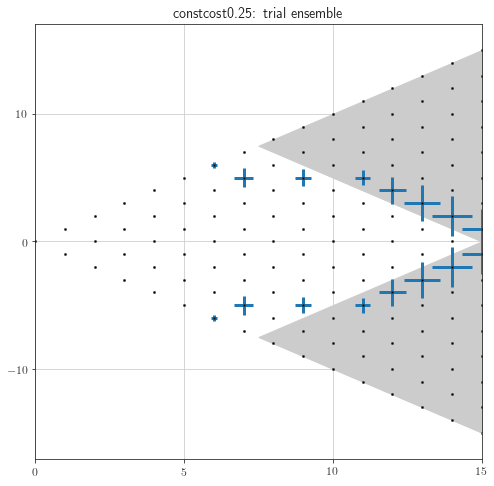

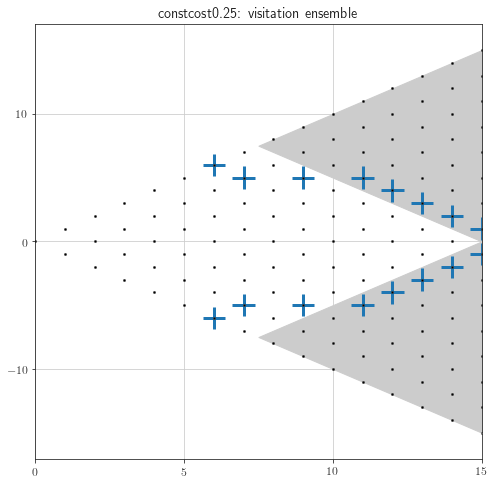

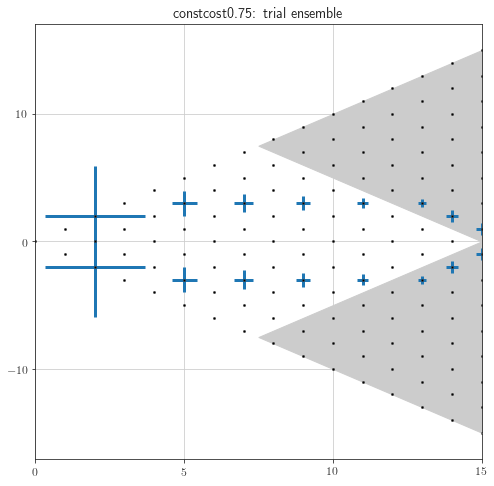

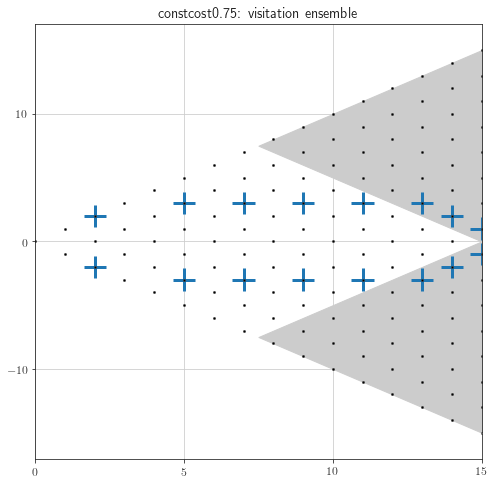

In [52]:
fig,ax=pl.subplots(1,3,figsize=(15,5))
figp,axp=pl.subplots()
col='rb'
alpvec=[0.25,0.75]
for it,alp in enumerate(alpvec):
#    

    Tavgvec=[]
#     rhovec=[]
#     bias_index_vec=[]
#     for cit,scalar_cost_value in enumerate([-0.05,-0.025,0,0.025,0.05]):
#     for cit,scalar_cost_value in enumerate(np.linspace(0,0.1,20)+1e-4):#[0,0.005,0.01,0.015,0.02]):
    cost_seq=np.zeros(para['T']+1)
#     cost_seq[0]=10#Ttrials[it]*(rhovec[it]-rhobar)
#     cost_seq=scalar_cost_value*np.ones(para['T']+1)
    rho_zero,data_boundary,dec_data,cost_seq,decide=get_DP_boundary(cost_seq,1-alp)
#     rhovec.append(rho_zero)

    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dfb=df_traj.copy()
    dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
    dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
    dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)
    
    dfb['pcorratDectime']=dfb.apply(lambda row:np.max([row.Pt_plus[int(row.tDecision)],1-row.Pt_plus[int(row.tDecision)]]),axis=1) 
#     dfb.pcorratDectime.plot.hist(ax=axp)
    dfb['localRR']=dfb.pcorratDectime/(dfb.tDecision+(1-alp)*(para['T']-dfb.tDecision)+para['T_ITI'])
    data=dfb.localRR.value_counts()
    axp.stem(data.index.values,data.values,linefmt =col[it],basefmt=" ")
#     data=dfb.pcorratDectime.value_counts()
#     axp.stem(data.index.values,data.values,linefmt =col[it],basefmt=" ")
    
    Tavgvec.append(dfb.tDecision.mean())
    if it==0 :#and cit==0:
        Tavg_slow=dfb.tDecision.mean()
        rho_slow=rho_zero
    if it==1:# and cit==1:
        rho_fast=rho_zero
        Tavg_fast=dfb.tDecision.mean()
#         if it==1 and cit==19:
    fig2,ax2=pl.subplots()
    figbase,axbase=pl.subplots()
    bias_index=plot_nocost_dec_times(dfb,pl,'constcost'+str(alp),axbase,ax2)


    ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(alp)+'$')#',$'+str(i)+'$')
    ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(alp)+'$')#',M$'+str(i)+'$')
#                 decision boundary in evidence space
    tb,b_evi=data_boundary[0]
    ax[0].plot(tb,b_evi+8*scalar_cost_value,'.-')
    ax[0].plot(tb,-b_evi,'k.-')
    print(cost_seq)
ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')
# ax[1].legend(frameon=False)

for Nm in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,para['T'])
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho_zero))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((para['T']+1,2*para['T']+1))
for t in range(para['T']+1):
    state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)

ax[0].set_ylim(-para['T'],para['T'])
ax[0].set_xlim(0,para['T'])
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# #     fig.savefig('inferred_const_costs'+str(post_interval)+'.pdf', transparent=True,dpi=300)